In [117]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


In [118]:
df = pd.read_csv("Output/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

# Drop duplicates
df = df.drop_duplicates('id', keep ='first')
print(df.shape)

(1000, 32)
(985, 32)


In [120]:
# Convert numeric cols to int/floats
df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Fill na for text cols
df["story"].fillna(" ", inplace = True)

df.state = df.state.astype('category').cat.codes

df.sample(1)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name
107,24,Quis Deo's First Full-Length Studio Album,"{'id': 241, 'name': 'Metal', 'slug': 'music/me...",745,US,2014-04-09 9:32,USD,2014-06-02 23:59,1.0,600,...,745.0,domestic,We are working with an awesome studio engineer...,[' '],0,Only backers can post comments. Log in\nNo com...,0.0,40,Music,Metal


### EDA

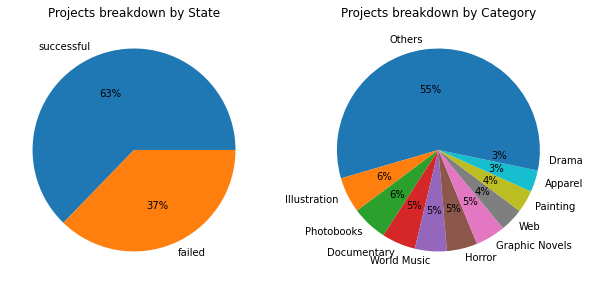

In [198]:
# Breakdown of project 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

# 1. by state
ax1.pie(df['state'].value_counts(), labels = ['successful', 'failed'], autopct='%1.0f%%')
ax1.set_title('Projects breakdown by State')

# 2. by category
# get top 10 categories
top_categories = df.groupby('category_name')['id'].count().reset_index().sort_values('id', ascending = False)[:10].category_name.tolist()
df['top_categories'] = np.where(df.category_name.isin(top_categories), df.category_name, 'Others')

ax2.pie(df['top_categories'].value_counts(), labels= df['top_categories'].unique().tolist(), autopct='%1.0f%%')
ax2.set_title('Projects breakdown by Category')

plt.show()

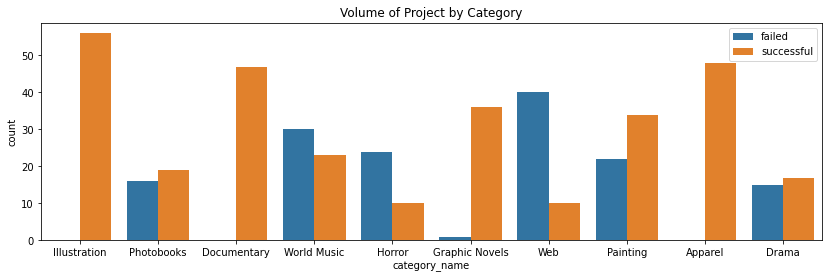

In [438]:
# Get the number of projects from top 10 most popular categories 
top_categories_df = df[df.category_name.isin(top_categories)]

plt.figure(figsize=(14,4))
g = sns.countplot(x='category_name', hue='state', data= top_categories_df)

g.set_title('Volume of Projects by Top 10 Category')
g.legend(['failed', 'successful'])

plt.show()

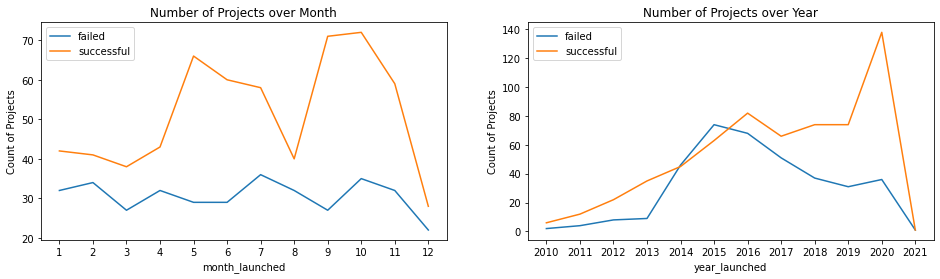

In [296]:
# Number of Projects launched over Time (month/ year)
df_month = df.groupby(['month_launched', 'state'])['id'].count().reset_index().rename(columns={'id':'Count of Projects'})
df_year = df.groupby(['year_launched', 'state'])['id'].count().reset_index().rename(columns={'id':'Count of Projects'})

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot('month_launched', 'Count of Projects', hue= 'state', data = df_month, ax=ax1)
ax1.set_title('Number of Projects over Month')
ax1.legend(['failed', 'successful'])
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

sns.lineplot('year_launched', 'Count of Projects', hue= 'state', data = df_year, ax=ax2)
ax2.set_title('Number of Projects over Year')
ax2.legend(['failed', 'successful'])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

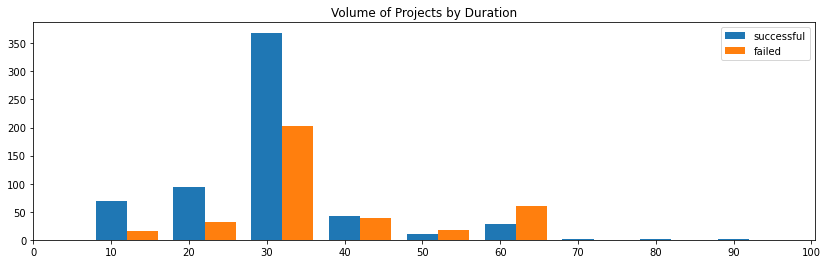

In [476]:
# Get the number of projects by duration
plt.figure(figsize=(14,4))

plt.hist([df[df.state==1].duration, df[df.state==0].duration], bins = range(min(df.duration), max(df.duration) + 10, 10), label= ['successful', 'failed'])

plt.title('Volume of Projects by Duration')
plt.legend(loc= 'best')
plt.xticks(np.arange(0, 110, 10))


plt.show()

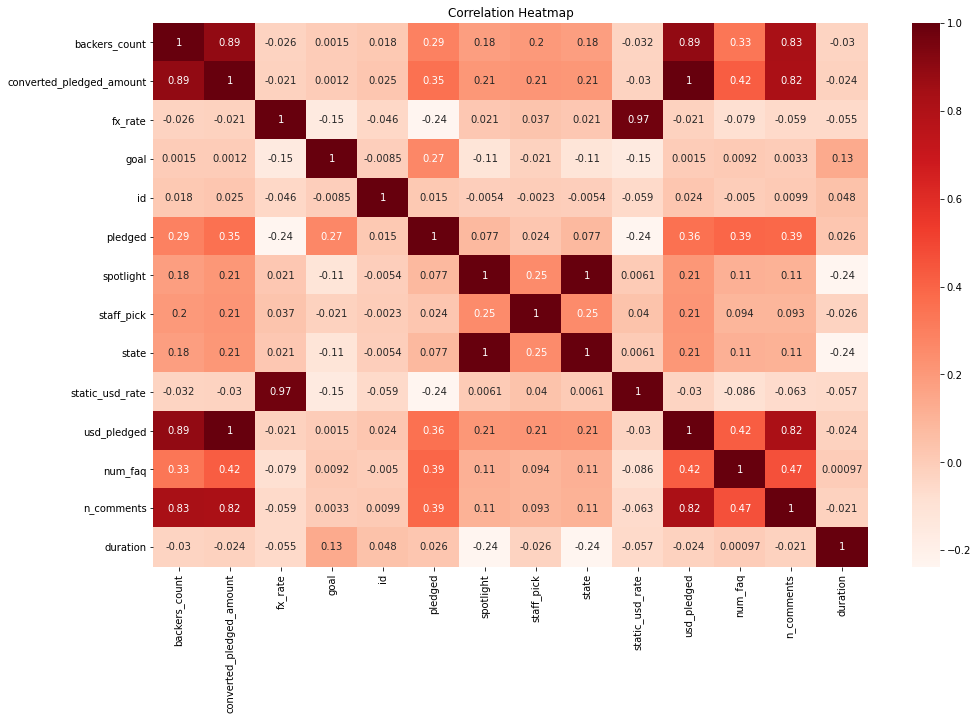

In [188]:
# Correlation heatmap
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds).set_title("Correlation Heatmap")

plt.show()

## Note: Move outlier detection to top and use the updated df from there

DF shape before dropping goals outliers:  (985, 38)
DF shape after dropping goals outliers:  (829, 38)


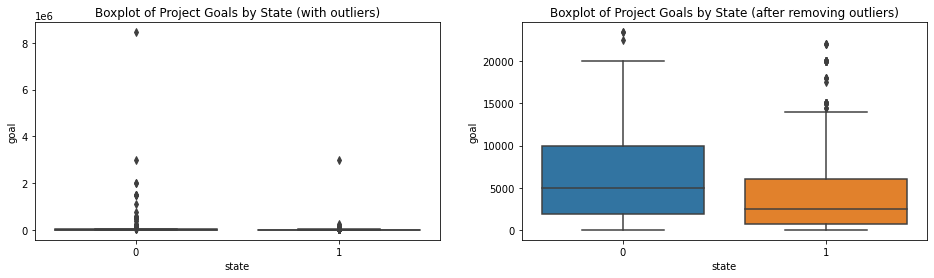

In [409]:
# Outlier Detection (Goals)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

sns.boxplot(y="goal", x="state", data=df, ax= ax1)
ax1.set_title('Boxplot of Project Goals by State (with outliers)')

from matplotlib.cbook import boxplot_stats

# drop 10 furthest outliers 
goal_outliers = sorted(set([y for stat in boxplot_stats(df['goal']) for y in stat['fliers']]))
df_drop_outliers1 = df[~df.goal.isin(goal_outliers)]

print('DF shape before dropping goals outliers: ', df.shape)
print('DF shape after dropping goals outliers: ', df_drop_outliers1.shape)

sns.boxplot(y="goal", x="state", data=df_drop_outliers1, ax= ax2)
ax2.set_title('Boxplot of Project Goals by State (after removing outliers)')

plt.show()

DF shape before dropping backers count outliers:  (829, 38)
DF shape after dropping backers count outliers:  (773, 38)


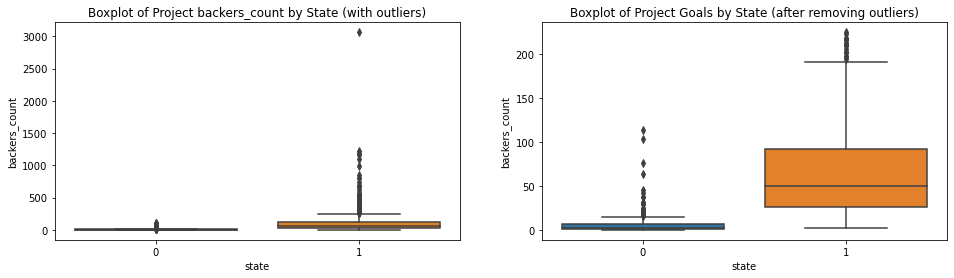

In [410]:
# Outlier Detection (Backers Count)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

sns.boxplot(y="backers_count", x="state", data= df_drop_outliers1, ax= ax1)
ax1.set_title('Boxplot of Project backers_count by State (with outliers)')

from matplotlib.cbook import boxplot_stats

# drop 10 furthest outliers 
backers_outliers = sorted(set([y for stat in boxplot_stats(df['backers_count']) for y in stat['fliers']]))
df_drop_outliers2 = df_drop_outliers1[~df_drop_outliers1.backers_count.isin(backers_outliers)]

print('DF shape before dropping backers count outliers: ', df_drop_outliers1.shape)
print('DF shape after dropping backers count outliers: ', df_drop_outliers2.shape)

sns.boxplot(y="backers_count", x="state", data=df_drop_outliers2, ax= ax2)
ax2.set_title('Boxplot of Project Goals by State (after removing outliers)')

plt.show()

In [ ]:
# Text feature counts
# n_comments , num_faq

In [124]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'current_currency', 'deadline', 'fx_rate',
       'goal', 'id', 'launched_at', 'location', 'name', 'pledged', 'profile',
       'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration', 'parent_category', 'category_name'],
      dtype='object')

In [ ]:

# plt.hist(df[df.state == 1]['goal'], bins=25, alpha=0.25, label='success', color='b')
# plt.hist(df[df.state == 0]['goal'], bins=25, alpha=0.5, label='fail', color='r')
# plt.legend(loc='upper right')

# sns.boxplot(x='category_name',y='goal',data=df)


### Feature Engineering

In [77]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)
# df['month_deadline'] = pd.DatetimeIndex(df['deadline']).month.astype(int)
# df['year_deadline'] = pd.DatetimeIndex(df['deadline']).year.astype(int)

In [6]:
cols_to_drop = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 'usd_pledged', 'converted_pledged_amount', 'spotlight', 'month_deadline', 'year_deadline']
df = df.drop(cols_to_drop, axis=1)

In [ ]:
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

### Text Analysis

In [8]:
# Text Analysis
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# create a new DataFrame column for sentiment 
for col in text_cols:
    col_name = col + '_sentiment'
    df[col_name] = df[col].apply(detect_sentiment)
    
df = df.drop(text_cols, axis=1)
df.head(3)

,backers_count,country,fx_rate,goal,pledged,staff_pick,state,usd_type,num_faq,n_comments,duration,month_launched,year_launched,parent_category,category_name,blurb_sentiment,name_sentiment,story_sentiment,faq_sentiment,comments_sentiment
0,1,ES,1.212886,15000,1.0,False,0,domestic,0,0.0,30,6,2016,Technology,3D Printing,0.0,0.0,0.160156,0.0,0.0
1,2,NZ,0.723585,5000,15.0,False,0,domestic,0,0.0,30,8,2015,Food,Farms,0.2,0.4,0.357143,0.0,0.0
2,0,US,1.000000,10000,0.0,False,0,domestic,0,0.0,29,4,2015,Art,Mixed Media,0.5,0.5,0.143182,0.0,0.0


### Feature Transformation

In [9]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [10]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [11]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

In [12]:
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [13]:
OHE_df # _sentiment cols

,backers_count,fx_rate,goal,pledged,num_faq,n_comments,duration,month_launched,year_launched,blurb_sentiment,...,category_name_Spaces,category_name_Stationery,category_name_Tabletop Games,category_name_Television,category_name_Video,category_name_Video Games,category_name_Web,category_name_Workshops,category_name_World Music,category_name_Young Adult
0,1,1.212886,15000,1.00,0,0.0,30,6,2016,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2,0.723585,5000,15.00,0,0.0,30,8,2015,0.200000,...,0,0,0,0,0,0,0,0,0,0
2,0,1.000000,10000,0.00,0,0.0,29,4,2015,0.500000,...,0,0,0,0,0,0,0,0,0,0
3,0,1.000000,2000,0.00,0,0.0,30,9,2014,0.150000,...,0,0,0,0,0,0,0,0,0,0
4,10,1.000000,2500,340.00,0,1.0,30,11,2014,0.200000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1.000000,225,386.00,0,0.0,12,5,2016,0.250000,...,0,0,0,0,0,0,0,0,0,0
996,36,1.000000,4000,4230.00,0,0.0,30,9,2012,0.568182,...,0,0,0,0,0,0,0,0,0,0
997,28,1.000000,2500,2516.00,0,0.0,22,6,2018,0.000000,...,0,0,0,0,0,0,0,0,0,0
998,3,1.000000,20,51.00,0,2.0,25,8,2017,-0.055556,...,0,0,0,0,0,0,0,0,0,0


In [14]:
OHE_df.columns.tolist()

['backers_count',
 'fx_rate',
 'goal',
 'pledged',
 'num_faq',
 'n_comments',
 'duration',
 'month_launched',
 'year_launched',
 'blurb_sentiment',
 'name_sentiment',
 'story_sentiment',
 'faq_sentiment',
 'comments_sentiment',
 'country_AT',
 'country_AU',
 'country_BE',
 'country_CA',
 'country_CH',
 'country_DE',
 'country_DK',
 'country_ES',
 'country_FR',
 'country_GB',
 'country_HK',
 'country_IE',
 'country_IT',
 'country_JP',
 'country_LU',
 'country_MX',
 'country_NL',
 'country_NO',
 'country_NZ',
 'country_SE',
 'country_SG',
 'country_US',
 'staff_pick_False',
 'staff_pick_True',
 'usd_type_domestic',
 'usd_type_international',
 'parent_category_Art',
 'parent_category_Comics',
 'parent_category_Crafts',
 'parent_category_Dance',
 'parent_category_Fashion',
 'parent_category_Film & Video',
 'parent_category_Food',
 'parent_category_Games',
 'parent_category_Journalism',
 'parent_category_Music',
 'parent_category_No Parent Category',
 'parent_category_Photography',
 'parent

In [15]:
int_cols = ['backers_count', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
OHE_df[int_cols] = OHE_df[int_cols].apply(lambda x: x.astype('int')) 

categorical_cols2 = []
for i in categorical_cols:
    categorical_cols2 += [col for col in OHE_df.columns if i in col]
    
OHE_df[categorical_cols2] = OHE_df[categorical_cols2].apply(lambda x: x.astype('category')) 

In [16]:
print(OHE_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 123 entries, backers_count to category_name_Young Adult
dtypes: category(109), float64(7), int32(6), int64(1)
memory usage: 202.7 KB
None


In [17]:
# # apply OneHotEncoder on categorical feature columns
# ohe = OneHotEncoder(handle_unknown = 'ignore') 

# X_train_ohe = ohe.fit_transform(X_train[categorical_cols]) 
# X_test_ohe = ohe.transform(X_test[categorical_cols])

# OHE_train = np.hstack((X_train.drop(categorical_cols, axis=1).values, X_train_ohe.toarray()))
# OHE_test = np.hstack((X_test.drop(categorical_cols, axis=1).values, X_test_ohe.toarray()))

### Text Analysis

In [18]:
# # Term Frequency (count the number of occurrences of each term in each document)
# # TfidfVectorizer (CountVectorizer + TfidfTransformer)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vect = TfidfVectorizer()
# pd.DataFrame(vect.fit_transform(X.comments).toarray(), columns=vect.get_feature_names())

In [19]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics

# # define a function that accepts a vectorizer and calculates the accuracy
# def tokenize_test(vect, col):
    
#     # create document-term matrices using the vectorizer
#     X_train_dtm = vect.fit_transform(X_train[col])
#     X_test_dtm = vect.transform(X_test[col])
    
#     # print the number of features that were generated
#     print('Features: ', X_train_dtm.shape[1])
    
#     # use Multinomial Naive Bayes to predict the star rating
#     nb = MultinomialNB()
#     nb.fit(X_train_dtm, y_train)
#     y_pred_class = nb.predict(X_test_dtm)
    
#     # print the accuracy of its predictions
#     print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [20]:
# # use TfidfVectorizer with default parameters
# vect = TfidfVectorizer()
# tokenize_test(vect, 'comments')

In [21]:
# # Term Frequency (count the number of occurrences of each term in each document)
# from sklearn.feature_extraction.text import CountVectorizer
# vect = CountVectorizer()
# tokenize_test(vect, 'comments')

In [22]:
# from afinn import Afinn

# afinn = Afinn(emoticons=True)
# afinn_scores = [afinn.score(text) for text in X.blurb]
# X['afinn_scores'] = afinn_scores
# X[['blurb', 'textblob_sentiment', 'afinn_scores']].head(20)

### DecisionTreeClassifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Build Model
dt_estimator = tree.DecisionTreeClassifier()
dt_estimator.fit(OHE_train, y_train)

DecisionTreeClassifier()

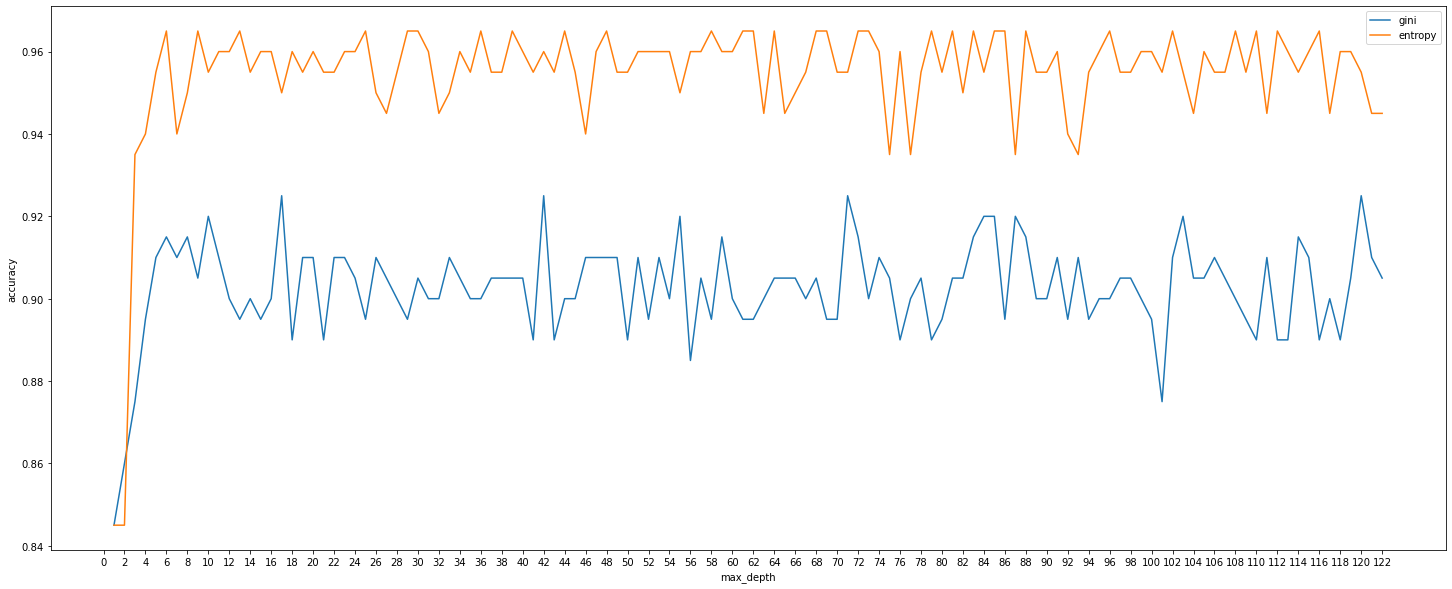

In [24]:
# DT Pruning
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, len(OHE_train.columns)):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(OHE_train, y_train)
    pred = dtree.predict(OHE_test)
    acc_gini.append(accuracy_score(y_test, pred))
####
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(OHE_train, y_train)
    pred = dtree.predict(OHE_test)
    acc_entropy.append(accuracy_score(y_test, pred))
####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy),'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.figure(figsize = (25, 10))
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xticks(np.arange(0, len(OHE_train.columns), 2))
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

In [35]:
# Evaluate Model 
dtree = DecisionTreeClassifier(criterion='entropy', max_depth= 6)
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)


The evaluation report is:
Confusion Matrix:
[[ 64   5]
 [  4 127]]
Accuracy: 0.955



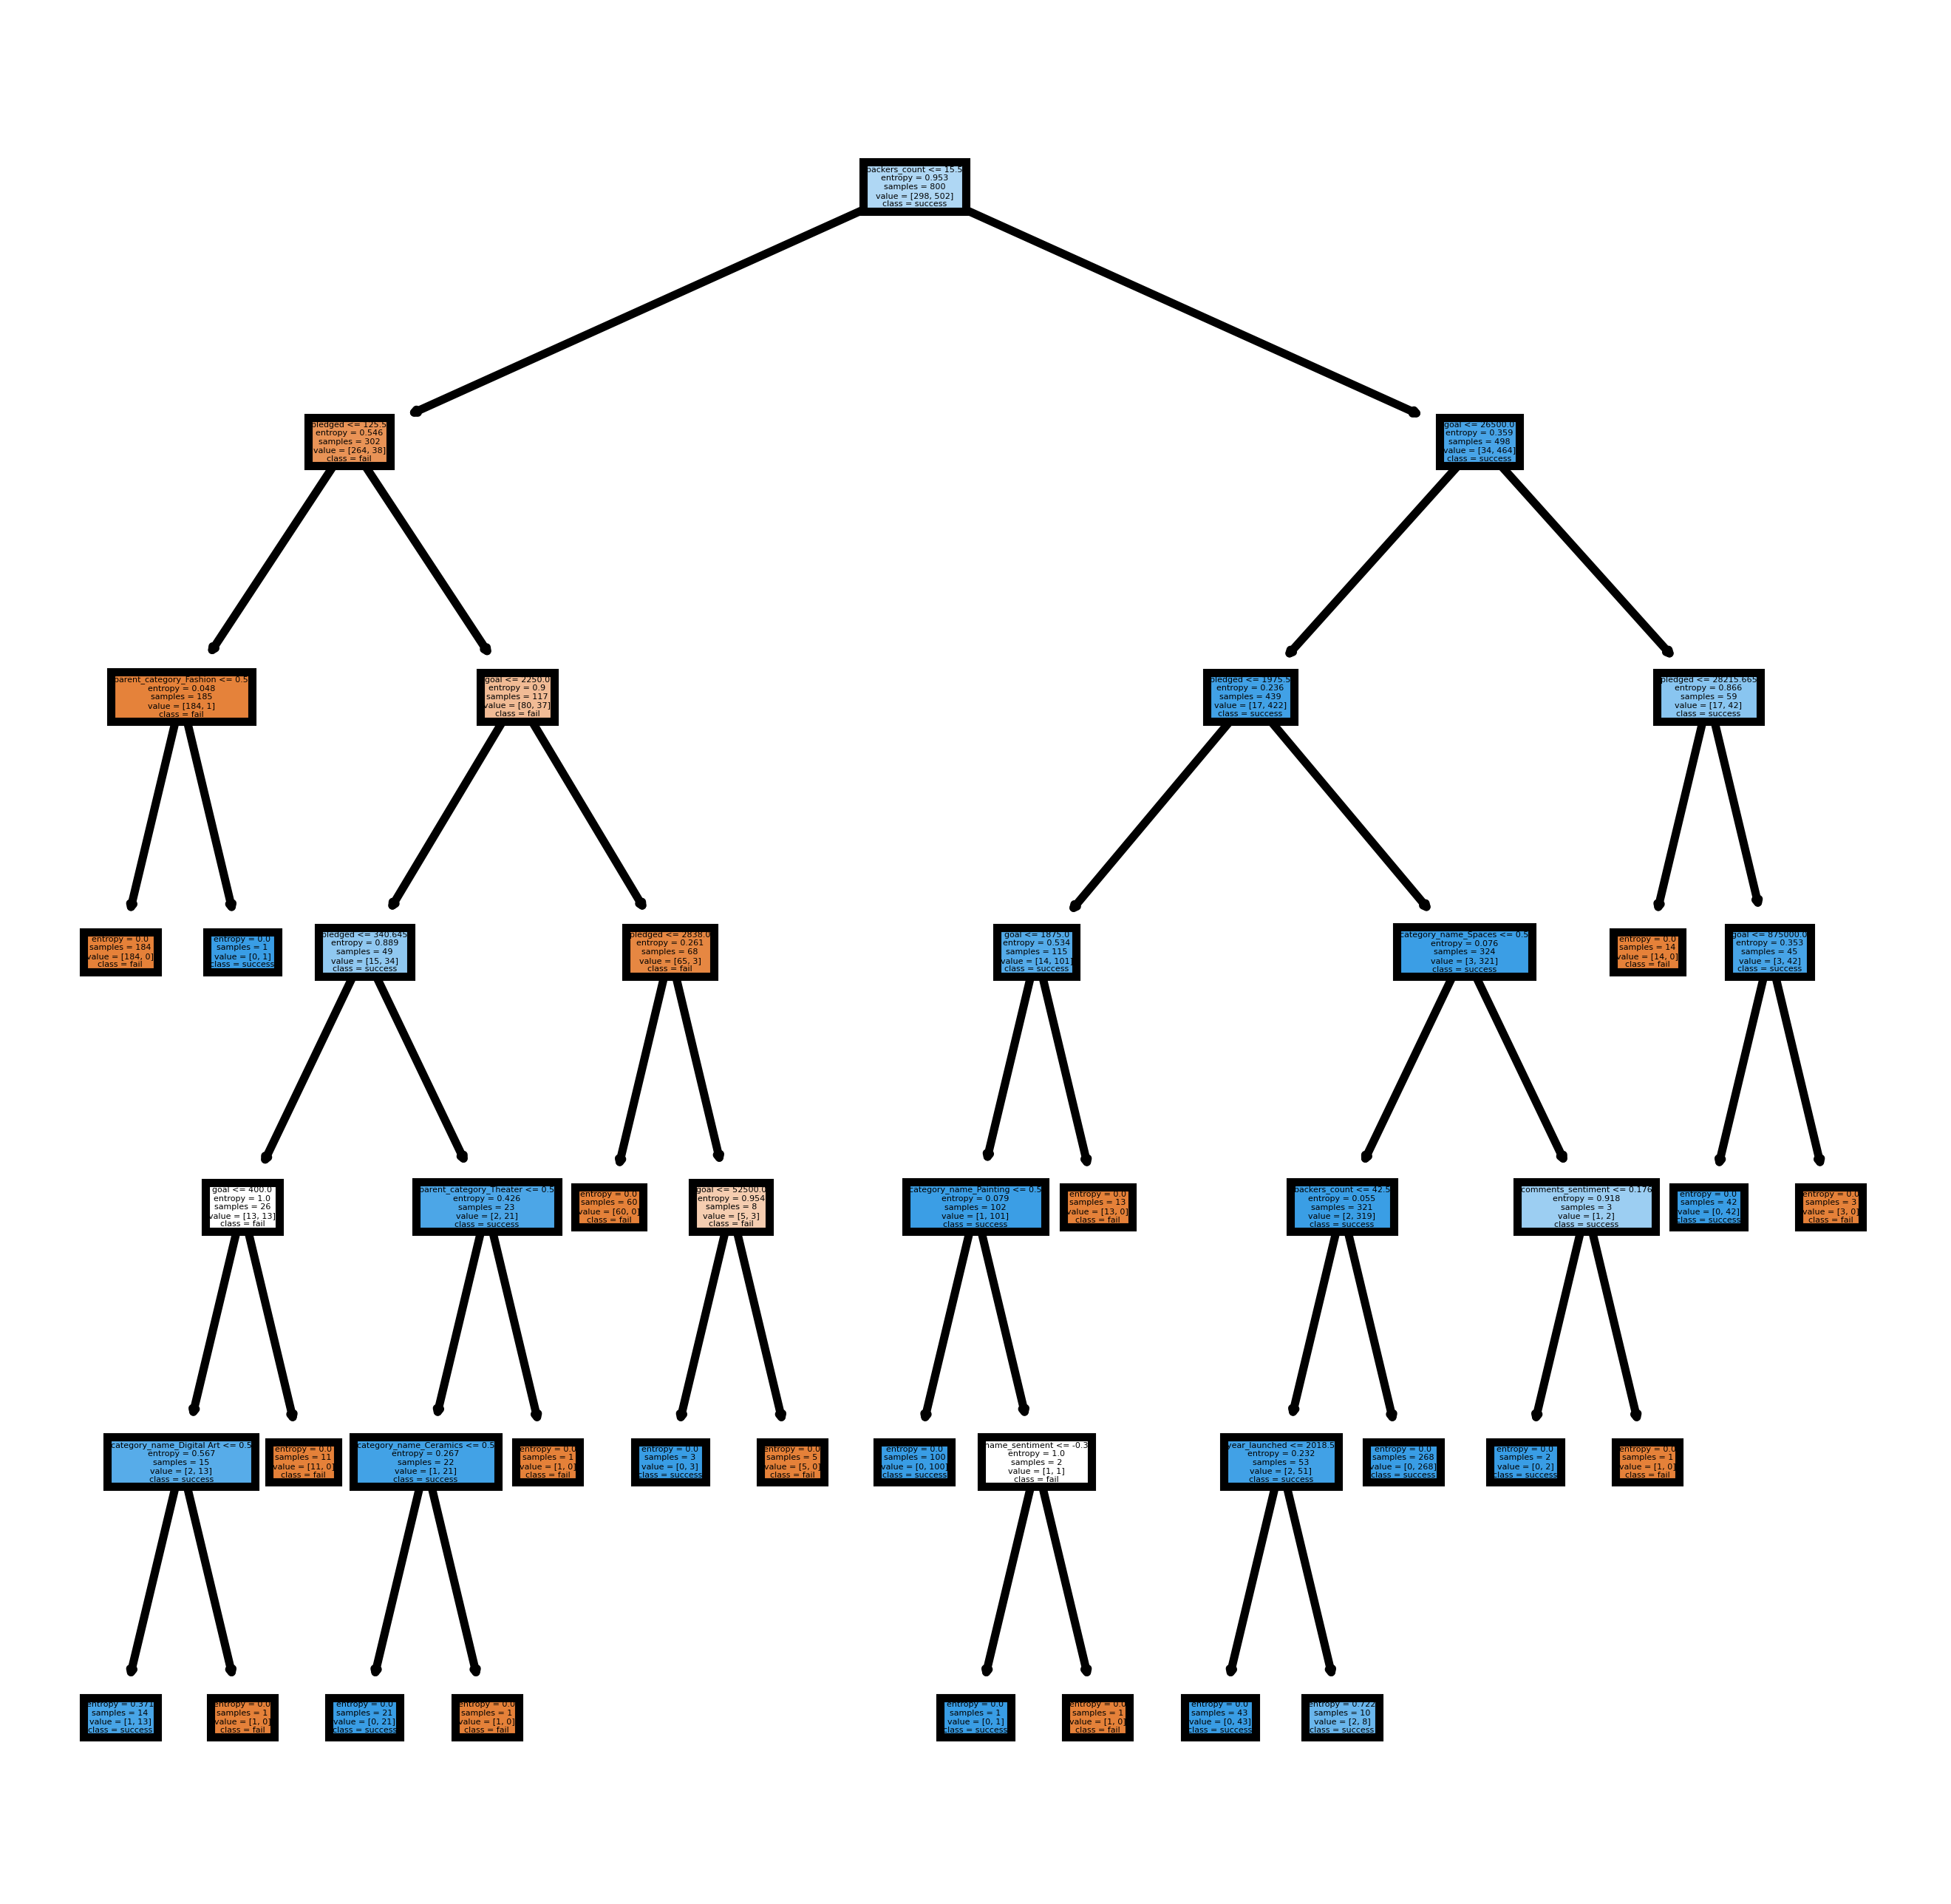

In [36]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

In [71]:
# Get Feature Importance
important_features_dict = {}
for idx, val in enumerate(dtree.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dtree.feature_importances_[top_idx]

print('Top 10 most important features: \n')

for i in range(10):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Top 10 most important features: 

1: backers_count, Score: 0.565 
2: goal, Score: 0.217 
3: pledged, Score: 0.162 
4: parent_category_Fashion, Score: 0.012 
5: category_name_Painting, Score: 0.008 
6: category_name_Ceramics, Score: 0.008 
7: year_launched, Score: 0.007 
8: category_name_Spaces, Score: 0.006 
9: parent_category_Theater, Score: 0.005 
10: category_name_Digital Art, Score: 0.004 


# TO CHECK

In [100]:
# CV -- CHECK 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt

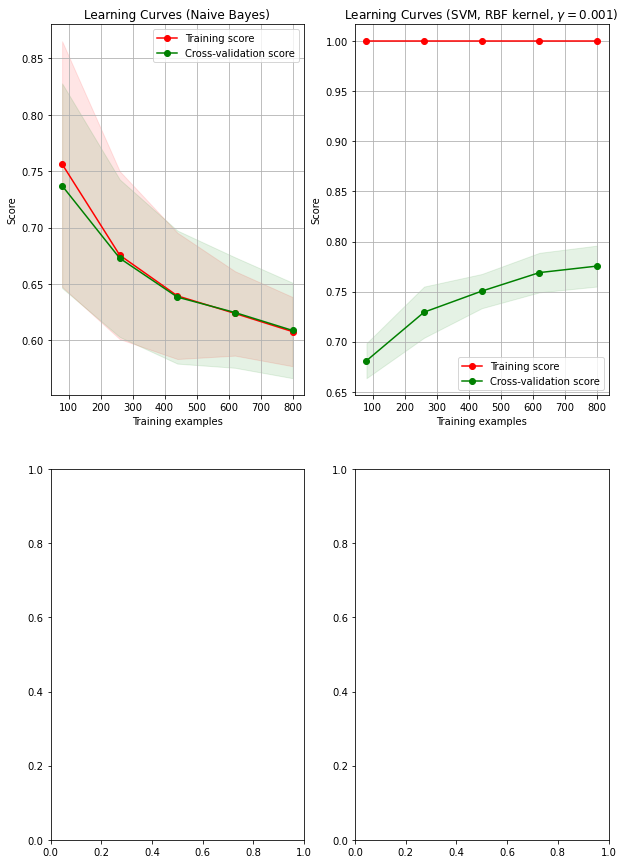

In [105]:
# CV -- CHECK 
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, OHE_df, y, axes=axes[:, 0], 
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, OHE_df, y, axes=axes[:, 1], 
                    cv=cv, n_jobs=4)

plt.show()

### DecisionTreeRegressor

In [27]:
# # Build Model
# x_reg = OHE_train
# y_reg = y_train

# dt_reg_estimator = tree.DecisionTreeRegressor()
# dt_reg_estimator.fit(x_reg, y_reg)

DecisionTreeRegressor()

In [28]:
# # Model Evaluation
# y_reg_predict = dt_reg_estimator.predict(OHE_test)
# print('MSE: {}'.format(mean_squared_error(y_test, y_reg_predict)))

MSE: 0.105
